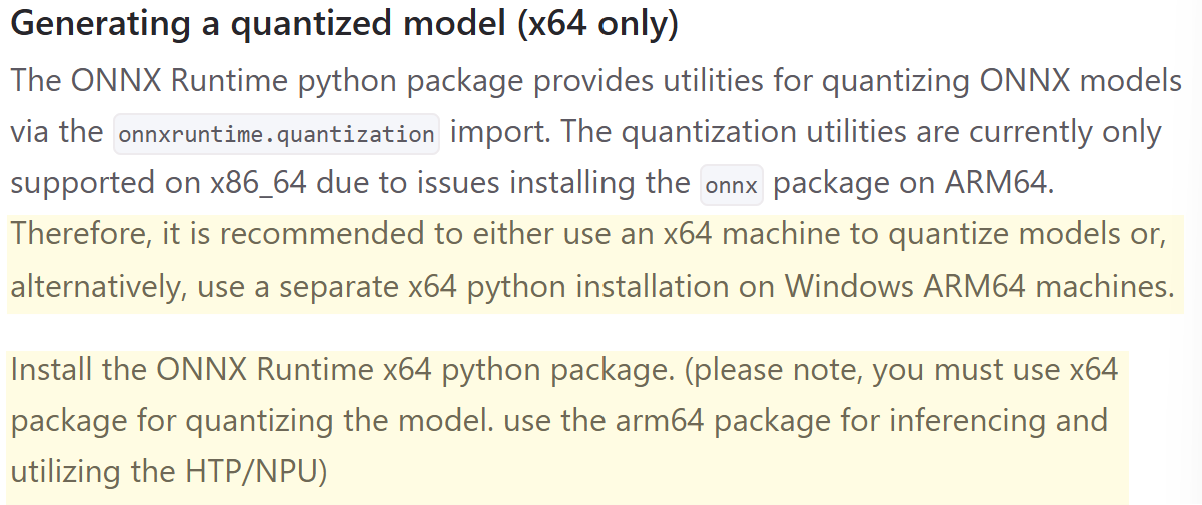
**What the heck is x86_64**

In [2]:
import numpy as np
import onnxruntime
import random
import torch
import os
import re

from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from onnxruntime.quantization import CalibrationDataReader
from PIL import Image
from typing import List,Tuple

random.seed(41)

https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/resnet50_data_reader.py

In [3]:
class DataReader(CalibrationDataReader):
    def __init__(self, model_path:str, dataset_path:str, img_max: int=10, verbose=False) -> None:
        self.enum_data = None

        self.session = onnxruntime.InferenceSession(model_path, provider=["CPUExecutionProvider"])
        self.expected_inputs = self.session.get_inputs()[0]
        
        #Need to use expected name and shape for model quantization
        self.expected_name = self.expected_inputs.name
        self.expected_shape = self.expected_inputs.shape
        self.data_list = []

        self.transformer = v2.Compose([
            v2.Resize(size=(self.expected_shape[2], 
                            self.expected_shape[3]),
                            interpolation=InterpolationMode.BICUBIC),
            v2.PILToTensor(),
            v2.ConvertImageDtype(torch.float32),
        ])
        self.re_mapper = re.compile(r"^C:\\.+?\\Human_Action_Recognition\\test\\(?P<image>Image_\d{1,4}).jpg")
                
        img_files = [os.path.join(dataset_path,file) for file in os.listdir(dataset_path) if file.endswith(".jpg")]
        random.shuffle(img_files)
        for file in img_files[:img_max]:
            img_pil = Image.open(file)
            img_transformed = self._image_transformer(frame=img_pil)
            if verbose:
                print(f"OG Image Shape: {np.array(img_pil).shape}")
                print(f"Transformed Shape: {img_transformed.shape}")
                
            # file_name = self.re_mapper.search(file).group("image")
            # input_data = {self.expected_name: img_transformed}
            
            # Updated this from resnet quantization example
            # https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/resnet50_data_reader.py
            self.data_list.append(img_transformed)
            
        self.data_size = len(self.data_list)    

    def _image_transformer(self, frame: Image) -> Image:
        transformed_frame = self.transformer(frame)
        transformed_frame_np = np.array(transformed_frame)
        return transformed_frame_np
        
        
    def get_next(self):
        # Updated this from resnet quantization example
        # https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/resnet50_data_reader.py
        if self.enum_data is None:
            self.enum_data = iter(
                [{self.expected_name: img_data} for img_data in self.data_list]
            )
        return next(self.enum_data, None)

    def rewind(self):
        self.enum_data = None

        



In [4]:
dataset_path = os.path.join("C:\\","Users","DFS","Desktop","datasets","Human_Action_Recognition","test")
dataset_path

'C:\\Users\\DFS\\Desktop\\datasets\\Human_Action_Recognition\\test'

https://onnxruntime.ai/docs/execution-providers/QNN-ExecutionProvider.html#running-a-model-with-qnn-eps-htp-backend-python

In [ ]:
from onnxruntime.quantization import QuantType, quantize
from onnxruntime.quantization.execution_providers.qnn import get_qnn_qdq_config, qnn_preprocess_model

base_path = os.path.join("..","models")
model_path = os.path.join(base_path,"hrnet_pose.onnx")
output_model_path = os.path.join(base_path,"hrnet_quantized.onnx")

#Pre-process original float32 model
pre_process_model_path = os.path.join(base_path,"hrnet_preprocessed.onnx")
model_diff = qnn_preprocess_model(model_path, pre_process_model_path)
model_to_quantize = pre_process_model_path if model_diff else model_path

iDataReader = DataReader(model_path=model_path, dataset_path=dataset_path, verbose=False)

qnn_config = get_qnn_qdq_config(model_to_quantize,
                                iDataReader,
                                activation_type=QuantType.QUInt16,
                                weight_type=QuantType.QUInt8)
qnn_config

quantize(model_to_quantize, output_model_path, qnn_config)

C:\Users\DFS\AppData\Local\Temp\ipykernel_18492\3707271917.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  transformed_frame_np = np.array(transformed_frame)


1. Download an x64 version of Python for windows (Windows x86-64) (not ARM64)
2. Install x64 Version
3. Set up windows alias for x64
4. Create virtual environment utilizing the x64 python
5. Activate virtual environment and rerun this notebook
   
**Generating a quantized model (x64 only)**
    
    The ONNX Runtime python package provides utilities for quantizing ONNX models via the onnxruntime.quantization import. The quantization utilities are currently only supported on x86_64 due to issues installing the onnx package on ARM64. Therefore, it is recommended to either use an x64 machine to quantize models or, alternatively, use a separate x64 python installation on Windows ARM64 machines.
    
    Install the ONNX Runtime x64 python package. (please note, you must use x64 package for quantizing the model. use the arm64 package for inferencing and utilizing the HTP/NPU)

Use this x64 python version
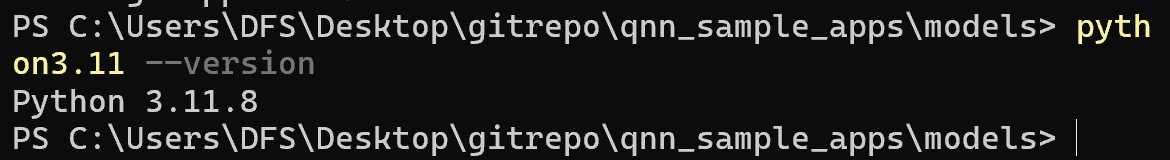